In [32]:
import numpy as np
import matplotlib.pyplot as plt
import copy


In [33]:
# Function to load the dataset
def load_data(file):
    data = []
    with open(file, 'r') as f:
        for line in f:
            line_data = line.strip().split()
            if len(line_data) == 2:
                try:
                    float_line_data = [float(value) for value in line_data]
                    data.append(float_line_data)
                except ValueError:
                    continue
    return np.array(data)

# Load the dataset
data = load_data('NLS_Group06.txt')

# Check if the dataset has the expected number of samples
num_samples = data.shape[0]
if num_samples != 2000:
    raise ValueError(f"Unexpected number of samples: {num_samples}. Expected 2000 samples.")

# Assign labels based on the assumption that the first 500 samples are class 1, next 500 are class 2, and last 1000 are class 3
samples_per_class = 500  # First 500 examples -> Class 1, next 500 -> Class 2, last 1000 -> Class 3
y = np.concatenate([
    np.ones(samples_per_class),                # Class 1 (label: 1)
    2 * np.ones(samples_per_class),            # Class 2 (label: 2)
    3 * np.ones(num_samples - 2 * samples_per_class)  # Class 3 (label: 3)
])

# Assign the feature matrix to X
X = data

# Print out the shape of X and y for verification
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Feature matrix shape: (2000, 2)
Labels shape: (2000,)


In [34]:
# Stratified train-test split function
def stratified_train_test_split(X, y, test_size=0.3):
    classes = np.unique(y)
    x_train_list, x_test_list = [], []
    y_train_list, y_test_list = [], []
    for cls in classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        n_samples = X_cls.shape[0]
        indices = np.random.permutation(n_samples)
        split_idx = int(n_samples * (1 - test_size))
        train_idx, test_idx = indices[:split_idx], indices[split_idx:]
        x_train_list.append(X_cls[train_idx])
        x_test_list.append(X_cls[test_idx])
        y_train_list.append(y_cls[train_idx])
        y_test_list.append(y_cls[test_idx])
    x_train = np.vstack(x_train_list)
    x_test = np.vstack(x_test_list)
    y_train = np.concatenate(y_train_list)
    y_test = np.concatenate(y_test_list)
    # Shuffle the training and test sets
    train_perm = np.random.permutation(len(y_train))
    test_perm = np.random.permutation(len(y_test))
    return x_train[train_perm], x_test[test_perm], y_train[train_perm], y_test[test_perm]

# Split the data
x_train, x_test, y_train, y_test = stratified_train_test_split(X, y)


In [35]:
# K-means clustering algorithm
def k_means(X, K, max_iters=100):
    n_samples, n_features = X.shape
    # Randomly initialize centroids from the data points
    centroids = X[np.random.choice(n_samples, K, replace=False)]
    for _ in range(max_iters):
        # Assignment step
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        assignments = np.argmin(distances, axis=1)
        # Update step
        new_centroids = np.array([X[assignments == k].mean(axis=0) if len(X[assignments == k]) > 0 else centroids[k] for k in range(K)])
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return assignments, centroids


In [36]:
# Multivariate Gaussian PDF function
def multivariate_gaussian_pdf(x, mean, cov):
    size = len(x)
    det_cov = np.linalg.det(cov + 1e-6 * np.eye(size))
    inv_cov = np.linalg.inv(cov + 1e-6 * np.eye(size))
    norm_const = 1.0 / (np.power((2 * np.pi), size / 2) * np.sqrt(det_cov))
    diff = x - mean
    exponent = -0.5 * np.dot(np.dot(diff.T, inv_cov), diff)
    return norm_const * np.exp(exponent)


In [37]:
def gmm_em(X, K, max_iters=100, tol=1e-4):
    N, D = X.shape
    K = min(K, N)  # Ensure K does not exceed the number of samples

    # K-means initialization
    assignments, means = k_means(X, K)

    # Initialize covariances and mixing coefficients
    covariances = []
    for k in range(K):
        if len(X[assignments == k]) > 1:  # Ensure there are enough points
            cov = np.cov(X[assignments == k].T) + 1e-6 * np.eye(D)  # Regularization
            covariances.append(cov)
        else:
            # If not enough data, use a small identity matrix
            covariances.append(1e-6 * np.eye(D))
    covariances = np.array(covariances)

    mixing_coeffs = np.array([np.mean(assignments == k) for k in range(K)])
    log_likelihoods = []

    for _ in range(max_iters):
        # E-step: Calculate responsibilities
        responsibilities = np.zeros((N, K))
        for k in range(K):
            for n in range(N):
                responsibilities[n, k] = mixing_coeffs[k] * multivariate_gaussian_pdf(X[n], means[k], covariances[k])
        
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True) + 1e-10  # Avoid division by zero

        # M-step: Update parameters
        N_k = np.sum(responsibilities, axis=0)
        means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]

        for k in range(K):
            covariances[k] = np.dot((responsibilities[:, k:k+1] * (X - means[k])).T, (X - means[k])) / N_k[k] + 1e-6 * np.eye(D)

        mixing_coeffs = N_k / N
        
        # Calculate log-likelihood
        log_likelihood = np.sum(np.log(np.sum(responsibilities, axis=1) + 1e-10))
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
            
    return means, covariances, mixing_coeffs, log_likelihoods


In [38]:
def train_gmms(x_train, y_train, K):
    classes = np.unique(y_train)
    class_gmm_params = {}
    for cls in classes:
        X_cls = x_train[y_train == cls]
        prior = len(X_cls) / len(x_train)
        means, covariances, mixing_coeffs, log_likelihoods = gmm_em(X_cls, K)
        class_gmm_params[cls] = {
            'means': means,
            'covariances': covariances,
            'mixing_coeffs': mixing_coeffs,
            'prior': prior,
            'log_likelihoods': log_likelihoods
        }
    return class_gmm_params


In [39]:
# Prediction function using GMMs
def predict_gmm(X, class_gmm_params):
    y_pred = []
    for x in X:
        posteriors = []
        for cls, params in class_gmm_params.items():
            means = params['means']
            covariances = params['covariances']
            mixing_coeffs = params['mixing_coeffs']
            prior = params['prior']
            # Compute the GMM likelihood
            likelihood = 0
            for k in range(len(mixing_coeffs)):
                likelihood += mixing_coeffs[k] * multivariate_gaussian_pdf(x, means[k], covariances[k])
            posterior = prior * likelihood
            posteriors.append((posterior, cls))
        y_pred.append(max(posteriors, key=lambda item: item[0])[1])
    return np.array(y_pred)


In [40]:
# Confusion matrix function
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i, true_cls in enumerate(classes):
        for j, pred_cls in enumerate(classes):
            matrix[i, j] = np.sum((y_true == true_cls) & (y_pred == pred_cls))
    return matrix

# Compute performance metrics
def compute_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    acc = np.trace(conf_matrix) / np.sum(conf_matrix)
    precision = np.zeros(len(classes))
    recall = np.zeros(len(classes))
    f1_score = np.zeros(len(classes))
    for idx in range(len(classes)):
        TP = conf_matrix[idx, idx]
        FP = np.sum(conf_matrix[:, idx]) - TP
        FN = np.sum(conf_matrix[idx, :]) - TP
        precision[idx] = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall[idx] = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score[idx] = (2 * precision[idx] * recall[idx]) / (precision[idx] + recall[idx]) if (precision[idx] + recall[idx]) > 0 else 0
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1_score)
    return acc, precision, recall, f1_score, mean_precision, mean_recall, mean_f1


In [41]:
def plot_decision_regions(X_train, y_train, class_gmm_params, resolution=0.01):
    markers = ('s', 'x', 'o')
    colors = ('red', 'blue', 'green')
    cmap = plt.cm.RdYlBu

    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]
    Z = predict_gmm(grid_points, class_gmm_params)
    Z = Z.reshape(xx1.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cls in enumerate(np.unique(y_train)):
        plt.scatter(x=X_train[y_train == cls, 0],
                    y=X_train[y_train == cls, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {int(cls)}',
                    edgecolor='black')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper left')
    plt.title('Decision Region Plot')
    plt.show()


In [42]:
def plot_density_contours(X_train, class_gmm_params, resolution=0.01):
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    grid_shape = xx1.shape
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]
    plt.figure(figsize=(10, 8))
    for cls, params in class_gmm_params.items():
        means = params['means']
        covariances = params['covariances']
        mixing_coeffs = params['mixing_coeffs']
        Z = np.zeros(len(grid_points))
        for k in range(len(mixing_coeffs)):
            Z += mixing_coeffs[k] * np.array([multivariate_gaussian_pdf(x, means[k], covariances[k]) for x in grid_points])
        Z = Z.reshape(grid_shape)
        plt.contour(xx1, xx2, Z, levels=5, alpha=0.75, cmap='RdYlBu')
    markers = ('s', 'x', 'o')
    colors = ('red', 'blue', 'green')
    for idx, cls in enumerate(np.unique(y_train)):
        plt.scatter(x=X_train[y_train == cls, 0],
                    y=X_train[y_train == cls, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {int(cls)}',
                    edgecolor='black')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper left')
    plt.title('Density Contour Plot')
    plt.show()


In [43]:
def plot_log_likelihoods(class_gmm_params, K):
    plt.figure(figsize=(10, 6))
    for cls, params in class_gmm_params.items():
        plt.plot(params['log_likelihoods'], label=f'Class {int(cls)}')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title(f'Log-Likelihood vs. Iterations for K={K}')
    plt.legend()
    plt.show()



Training GMMs with K=1 components...
Accuracy: 0.9583
Mean Precision: 0.9537
Mean Recall: 0.9500
Mean F1-Score: 0.9514


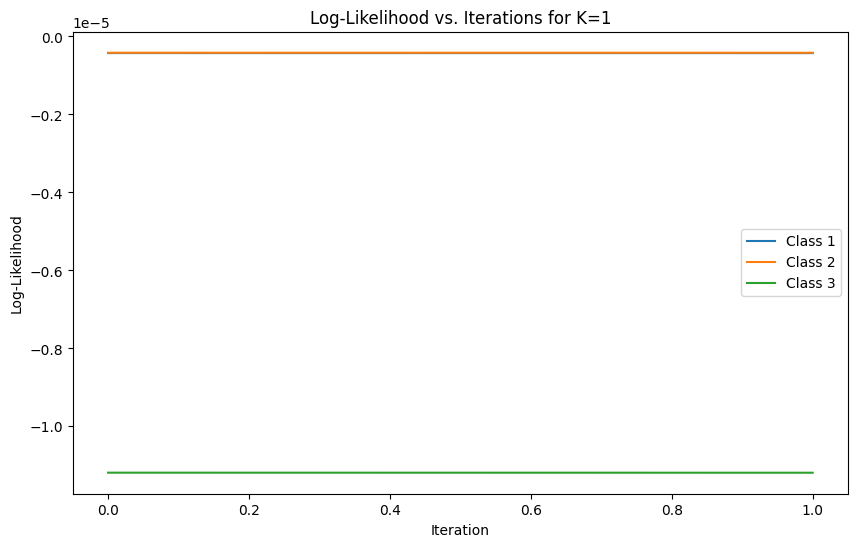


Training GMMs with K=2 components...
Accuracy: 0.9983
Mean Precision: 0.9978
Mean Recall: 0.9989
Mean F1-Score: 0.9983


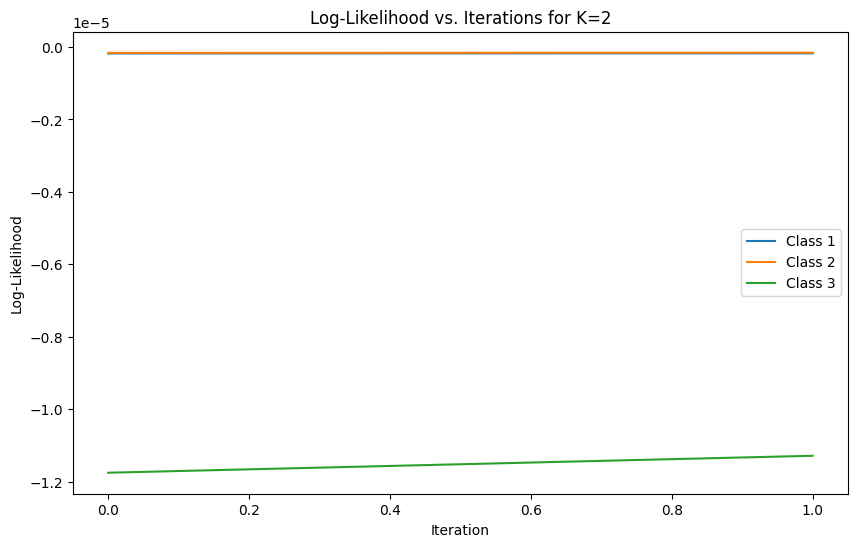


Training GMMs with K=4 components...
Accuracy: 1.0000
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-Score: 1.0000


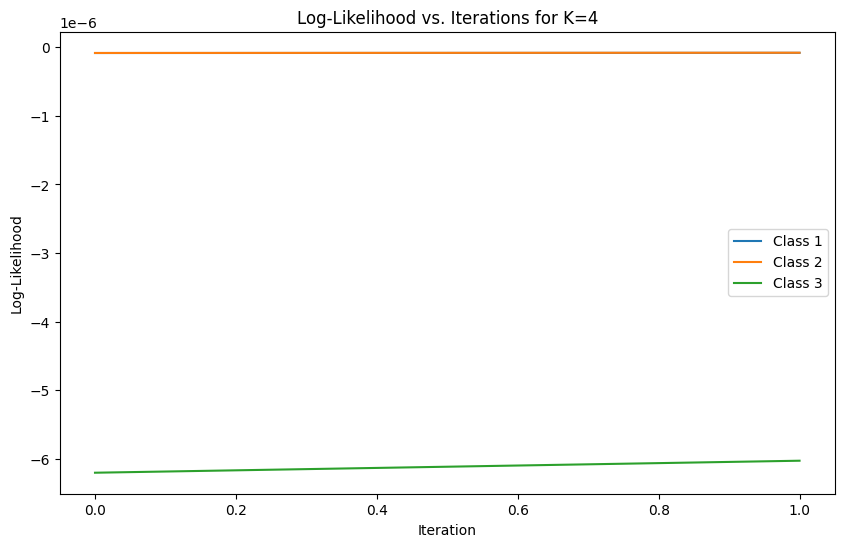


Training GMMs with K=8 components...
Accuracy: 1.0000
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-Score: 1.0000


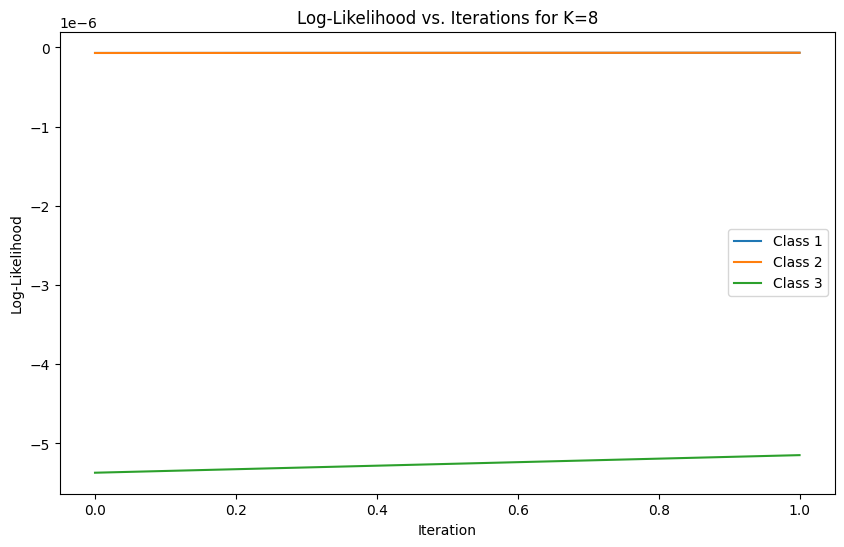


Training GMMs with K=16 components...
Accuracy: 1.0000
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-Score: 1.0000


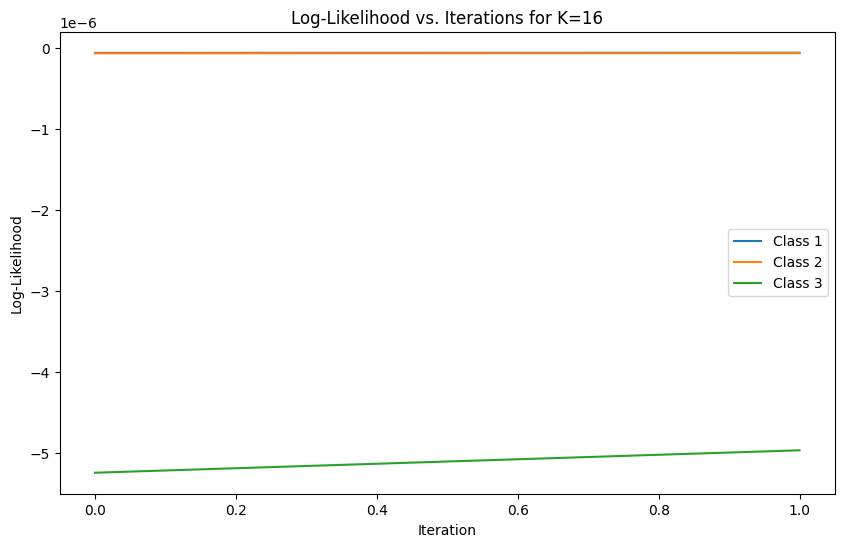


Training GMMs with K=32 components...
Accuracy: 1.0000
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-Score: 1.0000


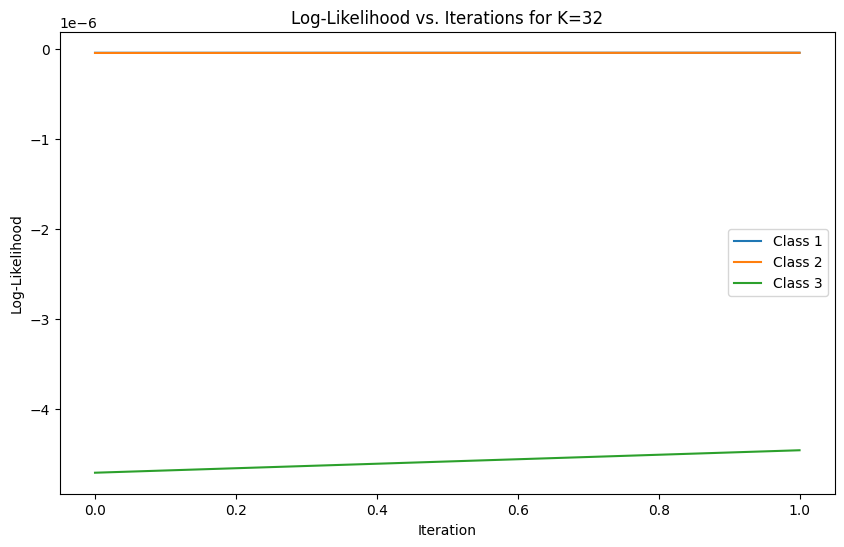


Training GMMs with K=64 components...
Accuracy: 1.0000
Mean Precision: 1.0000
Mean Recall: 1.0000
Mean F1-Score: 1.0000


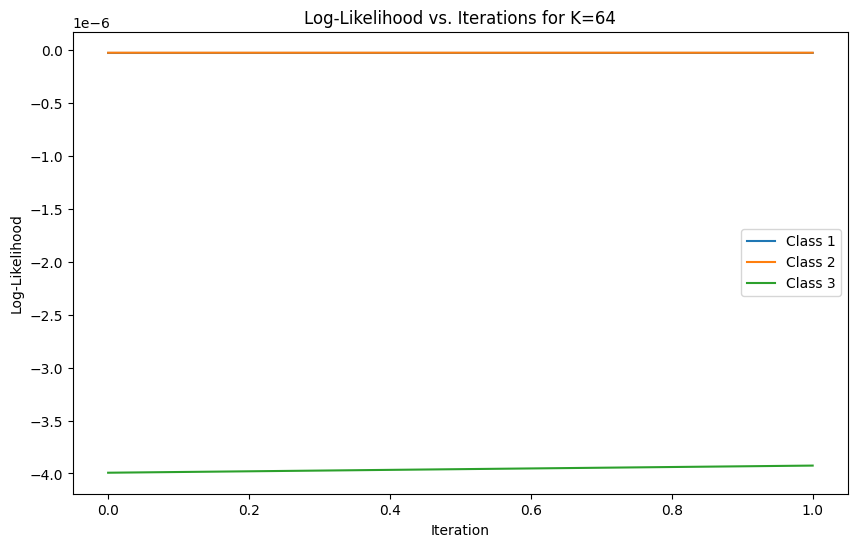

In [44]:
# Define the number of components to test
K_values = [1, 2, 4, 8, 16, 32, 64]

# Initialize a list to store the results
results = []

for K in K_values:
    print(f"\nTraining GMMs with K={K} components...")
    # Train GMMs for each class
    class_gmm_params = train_gmms(x_train, y_train, K)
    # Predict on test data
    y_pred = predict_gmm(x_test, class_gmm_params)
    # Compute metrics
    acc, precision, recall, f1_score, mean_precision, mean_recall, mean_f1 = compute_metrics(y_test, y_pred)
    results.append({
        'K': K,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_f1': mean_f1
    })
    # Print the metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")
    # Plot log-likelihoods
    plot_log_likelihoods(class_gmm_params, K)



Best model has K=4 components with accuracy 1.0000


/var/folders/j7/wxx13dwn2nb40s7lk13yrdsm0000gn/T/ipykernel_60422/3242149876.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X_train[y_train == cls, 0],


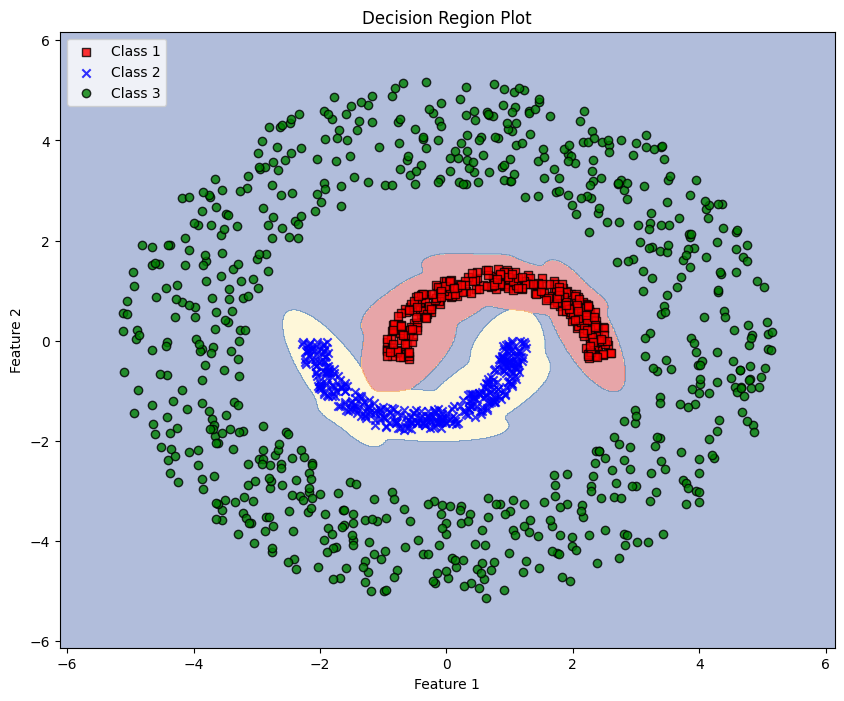

/var/folders/j7/wxx13dwn2nb40s7lk13yrdsm0000gn/T/ipykernel_60422/3244189683.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X_train[y_train == cls, 0],


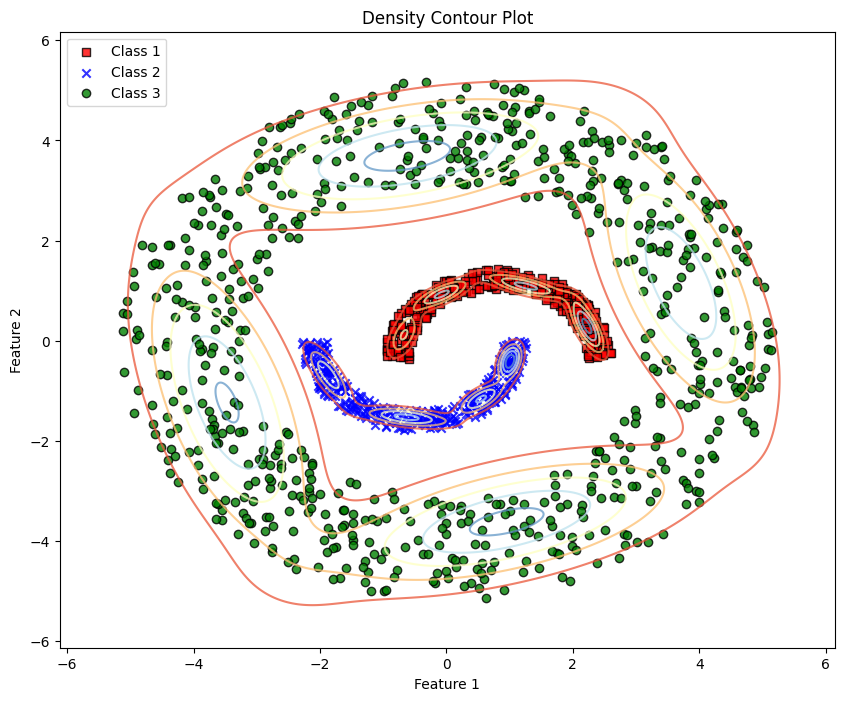


Confusion Matrix for the Best Model (K=4):
[[150   0   0]
 [  0 150   0]
 [  0   0 300]]
Accuracy: 1.0000
Precision per class: [1. 1. 1.]
Mean Precision: 1.0000
Recall per class: [1. 1. 1.]
Mean Recall: 1.0000
F1-Score per class: [1. 1. 1.]
Mean F1-Score: 1.0000


In [45]:
# Find the best model based on accuracy
best_result = max(results, key=lambda x: x['accuracy'])
best_K = best_result['K']
print(f"\nBest model has K={best_K} components with accuracy {best_result['accuracy']:.4f}")

# Retrain the best model to generate plots
class_gmm_params = train_gmms(x_train, y_train, best_K)

# Generate the required plots
plot_decision_regions(x_train, y_train, class_gmm_params)
plot_density_contours(x_train, class_gmm_params)

# Predict on test data using the best model
y_pred = predict_gmm(x_test, class_gmm_params)
# Compute confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred)
acc, precision, recall, f1_score, mean_precision, mean_recall, mean_f1 = compute_metrics(y_test, y_pred)

# Print confusion matrix and metrics
print(f"\nConfusion Matrix for the Best Model (K={best_K}):\n{conf_matrix}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision per class: {precision}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Recall per class: {recall}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"F1-Score per class: {f1_score}")
print(f"Mean F1-Score: {mean_f1:.4f}")


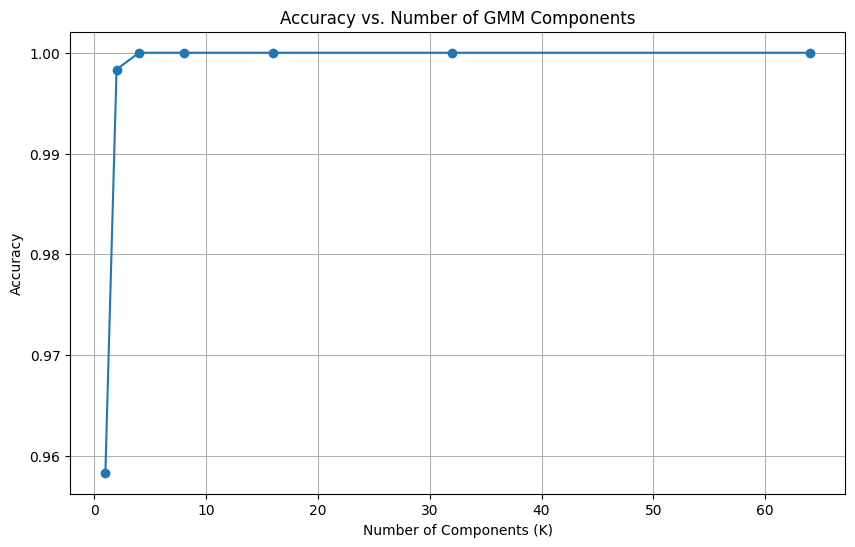

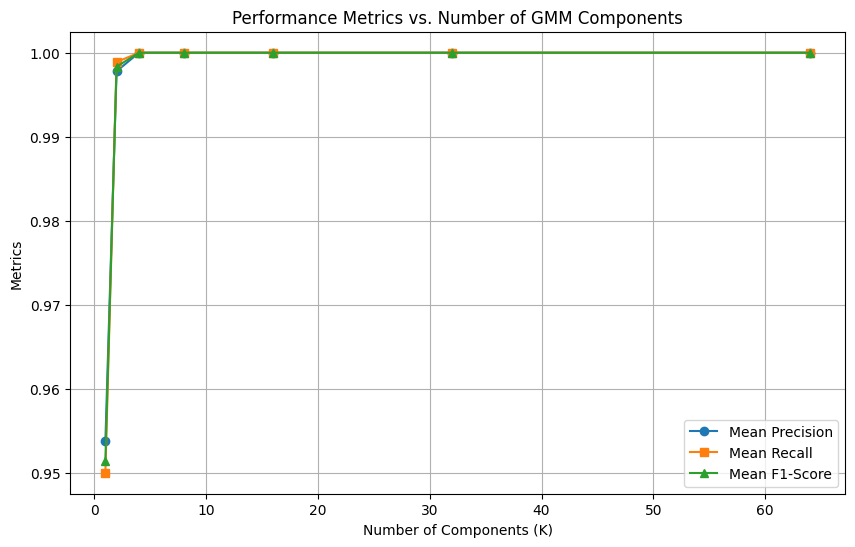

In [46]:
# Plot Accuracy vs. Number of Components
K_list = [result['K'] for result in results]
accuracy_list = [result['accuracy'] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(K_list, accuracy_list, marker='o')
plt.xlabel('Number of Components (K)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of GMM Components')
plt.grid(True)
plt.show()

# Similarly, you can plot Mean Precision, Mean Recall, and Mean F1-Score
mean_precision_list = [result['mean_precision'] for result in results]
mean_recall_list = [result['mean_recall'] for result in results]
mean_f1_list = [result['mean_f1'] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(K_list, mean_precision_list, marker='o', label='Mean Precision')
plt.plot(K_list, mean_recall_list, marker='s', label='Mean Recall')
plt.plot(K_list, mean_f1_list, marker='^', label='Mean F1-Score')
plt.xlabel('Number of Components (K)')
plt.ylabel('Metrics')
plt.title('Performance Metrics vs. Number of GMM Components')
plt.legend()
plt.grid(True)
plt.show()
